In [1]:
import pandas as pd

In [4]:
df = pd.read_csv("all_transactions.csv.gz", parse_dates=["Date"])
print(df.shape)
df.head()

(34817, 10)


,Date,Transaction Number,Net Amount,Supplier Name,Service Label,Service Division Label,Organisational Unit,Expenditure Category,CIPFA Detailed Expenditure Type,Narrative
0,2017-04-06,C010219,2925.22,New Recruits Professional Services Ltd,Operations and Delivery,Environmental Services,Environmental Services,Agency Staff,Employees,Agency Staff W/C 20/03/17
1,2017-04-06,C010220,668.22,New Recruits Professional Services Ltd,Operations and Delivery,Environmental Services,Environmental Services,Agency Staff,Employees,Agency Staff W/C 20/03/17
2,2017-04-06,C009848,996.09,Heathrow Truck Centre Ltd,Operations and Delivery,Environmental Services,Finance & Procurement,Vehicle Repair & Maintenance,Transport Related Expenditure,Annual order for 2016-2017
3,2017-04-06,C009417,988.00,Shelter Training & Publications,Commercial Development,Regeneration and Housing,Regeneration & Housing,Training,Employees,Arrears Management: The impact of universal cr...
4,2017-04-06,C010288,2000.00,The Mill Arts Centre,Operations and Delivery,Community Services,Finance & Procurement,Activities (workshop fees),Supplies and Services,Arts for Older People


In [5]:
df.dtypes

Date                               datetime64[ns]
Transaction Number                         object
Net Amount                                float64
Supplier Name                              object
Service Label                              object
Service Division Label                     object
Organisational Unit                        object
Expenditure Category                       object
CIPFA Detailed Expenditure Type            object
Narrative                                  object
dtype: object

# Annual spending

In [9]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

df[df["Year"] == 2016].groupby("Month")["Net Amount"].sum()

Month
4.0     6208877.34
5.0     3082735.97
6.0     3283590.03
7.0     3162282.83
8.0     3868237.58
9.0     2843161.55
10.0    2926690.31
11.0    4078824.46
12.0    2741064.63
Name: Net Amount, dtype: float64

Let's assume we just don't have all of 2016 and drop it

In [10]:
df = df[df["Year"] > 2016]

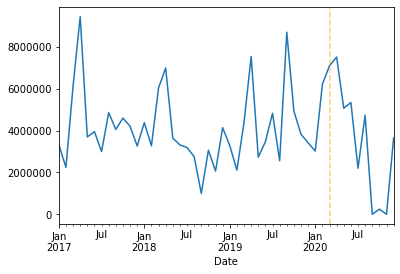

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df.set_index("Date").resample("MS")["Net Amount"].sum().plot(ax=ax)

ax.axvline("2020-03-01", color="orange", linestyle="dashed", alpha=0.5)

plt.show()

# High level spending categories by year

In [29]:
annual_top_5 = (
    df
        .groupby("Year")
        ["Expenditure Category"].value_counts(normalize=True)
        .reset_index(name="count")
        .groupby(["Year"])
        .apply(lambda x: x.head(5))
        .drop("Year", axis=1)
)

annual_top_5

Expenditure Category     count
Year                                              
2017.0 0                      Stationery  0.125933
       1                    Agency Staff  0.122845
       2    Contractors Capital Payments  0.087986
       3                Consultants Fees  0.051711
       4                Payment Refunded  0.033059
2018.0 151                    Stationery  0.127059
       152                  Agency Staff  0.125882
       153  Contractors Capital Payments  0.093765
       154              Consultants Fees  0.049647
       155          Repair & Maintenance  0.043059
2019.0 279                    Stationery  0.104696
       280                  Agency Staff  0.098855
       281  Contractors Capital Payments  0.085452
       282     Other Prof.Fees (Capital)  0.058076
       283  Vehicle Repair & Maintenance  0.056586
2020.0 404  Contractors Capital Payments  0.090870
       405                  Agency Staff  0.089565
       406                    Stationery  0.085435
       407              Consultants Fees  0.068478
       408          Repair & Maintenance  0.055217

In [49]:
annual_top_5_wide = (
    annual_top_5
        .reset_index()
        .drop("level_1", axis=1)
        .set_index(["Expenditure Category", "Year"])
        .unstack()
        .fillna(0)
        .round(2)
        * 100
        
)

annual_top_5_wide

count                     
Year                         2017.0 2018.0 2019.0 2020.0
Expenditure Category                                    
Agency Staff                   12.0   13.0   10.0    9.0
Consultants Fees                5.0    5.0    0.0    7.0
Contractors Capital Payments    9.0    9.0    9.0    9.0
Other Prof.Fees (Capital)       0.0    0.0    6.0    0.0
Payment Refunded                3.0    0.0    0.0    0.0
Repair & Maintenance            0.0    4.0    0.0    6.0
Stationery                     13.0   13.0   10.0    9.0
Vehicle Repair & Maintenance    0.0    0.0    6.0    0.0

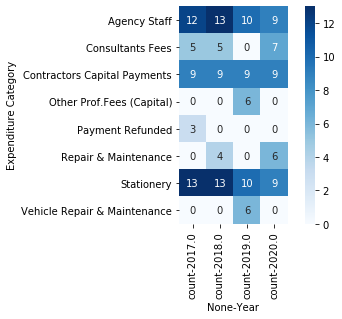

In [51]:
import seaborn as sns

sns.heatmap(annual_top_5_wide,
            square=True,
            cmap="Blues",
            annot=True
           );

# Do this properly

The zeros above are false because we considered top 5 per year, and that changes, so 0 indicates "category was not in the top 5 that year" and not "0 items for that category".

Let's do it properly and tabulate year and spend category:

In [64]:
annual_by_category = (
    pd.crosstab(
        index=df["Expenditure Category"],
        columns=df["Year"],
        values=df["Net Amount"],
        aggfunc="sum",
        normalize="columns"
    )
    .fillna(0)
)
annual_by_category

Year,2017.0,2018.0,2019.0,2020.0
Expenditure Category,,,,
Acquisition Computer Hardware,0.000017,0.000000,0.000000,0.000000
Acquisition of Plant / Machinery,0.018992,0.000665,0.000000,0.000000
Activities (workshop fees),0.000095,0.000229,0.000254,0.000415
Added Years Pension and Pension Compensa,0.007564,0.000000,0.003117,0.000000
Additional DFG direct from Government,0.000000,0.002460,0.001774,0.001364
...,...,...,...,...
Vets Fees,0.000020,0.000095,0.000045,0.000000
Water Charges (Metered),0.000496,0.000776,0.000429,0.000407
Water Sampling,0.000016,0.000000,0.000017,0.000000


## Remove categories that never made it above 1% of spend for the year

In [65]:
annual_by_category["max_annual_spend"] = annual_by_category.max(axis=1)

In [66]:
big_items_only = annual_by_category[annual_by_category["max_annual_spend"] > 0.01]

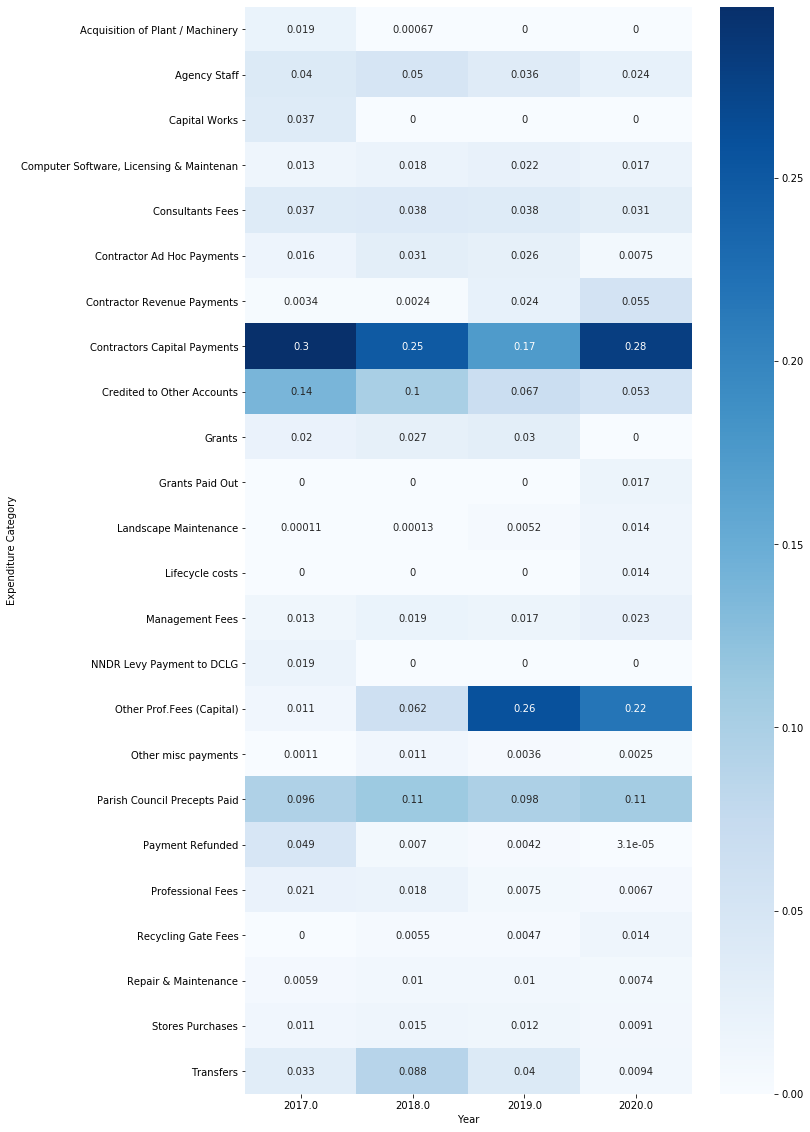

In [69]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 20))

sns.heatmap(big_items_only.drop("max_annual_spend", axis=1),
            #square=True,
            cmap="Blues",
            annot=True,
            ax=ax
           )

plt.show()